In [39]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

import chugunov_indicator as chug

In [40]:
from pynucastro.constants import constants
from pynucastro.screening.screen import f0

In [41]:
q = 1/3

With $q = 1/3$, we define
$$
    A := \rho \sqrt[3]{T} = (T \rho^3)^q, \quad B := \sqrt[3]{\rho}/T = (\rho/T^3)^q.
$$
in other words, we have a rotation and scaling
$$
    a = q(3d + t), \quad b = q (d - 3 t).
$$
where $A = 10^a$ and so on. This gives
$$
    t = \frac{1}{10q} (a - 3b), \quad d = \frac{1}{10q} (3a + b),
$$
or in other words,
$$
    T = (A/B^3)^{1/10q}, \quad D = (B A^3)^{1/10q}.
$$

In [42]:
def TD_to_AB(T: float, D: float) -> tuple[float, float]:
    return (T*D**3)**q, (D/T**3)**q

def AB_to_TD(A: float, B: float) -> tuple[float, float]:
    return (A/B**3)**(3/10), (B*A**3)**(3/10)

In [43]:
A_ = np.logspace(-5*q, 33.35*q, num=200)
B_ = np.logspace(-32.05*q, -13*q, num=200)
A, B = np.meshgrid(A_, B_)

In [44]:
T, D = AB_to_TD(A, B)

In [45]:
starting_kwargs = {
    "abar": 4.028776983649795,
    "zbar": 2,
    "z2bar": 4.12949645671095,
    "z1": 2,
    "z2": 6
}

fixed_kwargs = {
    "a1": 4,
    "a2": 12
}

In [46]:
F = chug.chugunov_2009(T=T, D=D, **starting_kwargs, **fixed_kwargs)

interactive(children=(FloatSlider(value=26.71982722216236, description='abar', max=52.43965444432472, min=1.0)…

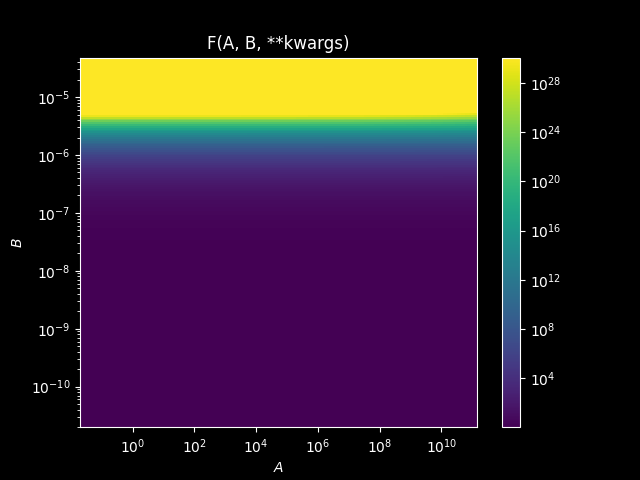

In [47]:
%matplotlib widget

fig1, ax1 = plt.subplots()

params1 = {
    "abar": (1, 52.43965444432472),
    "zbar": (1., 100.),
    "z2bar": (1., 713.3104742534674),
    "z1": (1, 20),
    "z2": (1, 20)
}


ax1.set_title("F(A, B, **kwargs)")

ax1.set_xlabel("$A$")
ax1.set_ylabel("$B$")

ax1.set_xscale("log")
ax1.set_yscale("log")

# Create initial plot
cb = ax1.pcolormesh(A, B, F, norm="log")
cbar = fig1.colorbar(cb)

# Create function to be called when slider value is changed
@interact(**params1)
def update1(**kwargs) -> None:
    F = chug.chugunov_2009(T, D, **kwargs, **fixed_kwargs)
    cb.set_array(F)
    cb.changed()

# Show graph
#fig1.show()

As expected, $A$ only matters at very high values of $F$. This effect is more pronounced when $\bar{Z}$ is high.

In [48]:
dF = np.gradient(F, A_, B_)

In [49]:
dF[0].min(), np.median(dF[0]), dF[0].max()

(3.7400706818769335e-08, 6.619078789051719e-07, 6.563754009488593e+19)

In [50]:
A__ = 10**4
B__ = np.logspace(-32.05*q, -13*q, num=1000)

T__, D__ = AB_to_TD(A__, B__)

In [51]:
F__ = chug.chugunov_2009(T=T__, D=D__, **starting_kwargs, **fixed_kwargs)

interactive(children=(FloatSlider(value=1.0, description='abar', max=52.43965444432472, min=1.0), FloatSlider(…

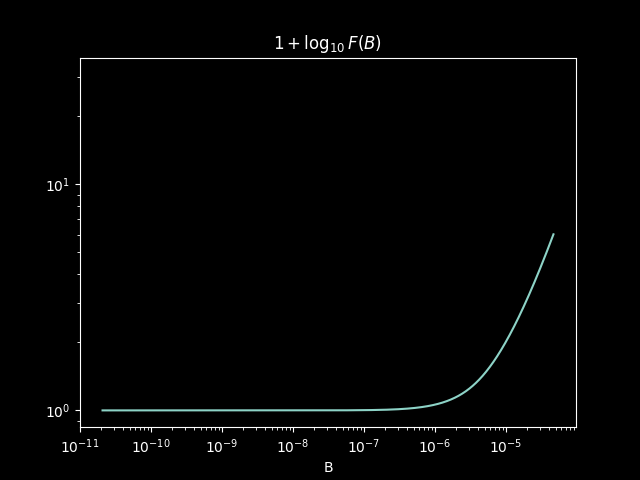

In [52]:
fig2, ax2 = plt.subplots()

params2 = {
    "abar": FloatSlider(value=1, min=1, max=52.43965444432472),
    "zbar": FloatSlider(value=1, min=1, max=100),
    "z2bar": FloatSlider(value=1, min=1, max=713.3104742534674),
    "z1": IntSlider(value=1, min=1, max=20),
    "z2": IntSlider(value=1, min=1, max=20),
    "A__": FloatSlider(value=1, min=1, max=33.35*q)
}

ax2.set_title("$1 + \\log_{10} F(B)$")

ax2.set_xlabel("B")
ax2.set_xscale("log")
ax2.set_yscale("log")

# Create initial plot
new_line, = ax2.plot(B__, 1 +np.log10(F__))

# Create function to be called when slider value is changed
@interact(**params2)
def update2(**kwargs) -> None:
    A__new = 10**kwargs["A__"]
    del kwargs["A__"]

    T__new, D__new = AB_to_TD(A__new, B__)

    F__new = chug.chugunov_2009(T__new, D__new, **kwargs, **fixed_kwargs)

    new_line.set_ydata(1 + np.log10(F__new))

# Show graph
#fig2.show()

As before, $A$ only affects $F$ at high $B$.

From here, notice that
$$
    \Gamma_e \propto \sqrt[3]{\rho \frac{\bar{Z}}{\bar{A}}} \frac{1}{T} = B \gamma_e \sqrt[3]{\frac{\bar{Z}}{\bar{A}}},
$$
where the proportionality constant $\gamma_e$ is the remaining factors in equation 6 of the original paper. In other words, $B$ is the portion of $\Gamma_e$ that depends only on $\rho, T$.

Since most of `chugunov_2009` is dependent on $\Gamma_e$, the intercept problem in the previous notebooks is equivalent to solving $F(\Gamma_e) < 1.01$. Its complement $A$ is simply the other half of the dependence on $\rho, T$.

In [53]:
def F_fit(
        T: float, D: float,
        abar: float, zbar: float, z2bar: float,
        z1: int, z2: int,
        a1: int, a2: int,
    ) -> float:
    """Calculates screening factors based on :cite:t:`chugunov:2009` in `NumPy`-friendly form.

    :param PlasmaState state:     the precomputed plasma state factors
    :param ScreenFactors scn_fac: the precomputed ion pair factors
    :returns: screening correction factor
    """

    # Precomputed Values
    mbar = abar * constants.m_u
    ntot = D / mbar

    # Electron number density
    # zbar * ntot works out to sum(z[i] * n[i]), after cancelling terms
    n_e = zbar * ntot

    # temperature-independent part of Gamma_e, from Chugunov 2009 eq. 6
    gamma_e_fac = constants.q_e ** 2 / constants.k * np.cbrt(4 * np.pi / 3) * np.cbrt(n_e)

    aznut = np.cbrt(z1 ** 2 * z2 ** 2 * a1 * a2 / (a1 + a2))
    ztilde = 0.5 * (np.cbrt(z1) + np.cbrt(z2))

    # z1z2 and zcomp
    z1z2 = z1 * z2
    zcomp = z1 + z2

    # Gamma_e from eq. 6
    Gamma_e = gamma_e_fac / T

    # Coulomb coupling parameters for ions and compound nucleus, eqs. 7 & 9
    Gamma_1 = Gamma_e * z1 ** (5 / 3)
    Gamma_2 = Gamma_e * z2 ** (5 / 3)
    Gamma_comp = Gamma_e * zcomp ** (5 / 3)

    Gamma_12 = Gamma_e * z1z2 / ztilde

    # Coulomb barrier penetrability, eq. 10
    tau_factor = np.cbrt(27 / 2 * (np.pi * constants.q_e ** 2 / constants.hbar) ** 2 * constants.m_u / constants.k)
    tau_12 = tau_factor * aznut / np.cbrt(T)

    # eq. 12
    zeta = 3 * Gamma_12 / tau_12

    # additional fit parameters, eq. 25
    y_12 = 4 * z1z2 / zcomp ** 2
    c1 = 0.013 * y_12 ** 2
    c2 = 0.406 * y_12 ** 0.14
    c3 = 0.062 * y_12 ** 0.19 + 1.8 / Gamma_12

    poly = 1 + zeta*(c1 + zeta*(c2 + c3*zeta))
    t_12 = np.cbrt(poly)

    # strong screening enhancement factor, eq. 23, replacing tau_ij with t_ij
    # Using Gamma/tau_ij gives extremely low values, while Gamma/t_ij gives
    # values similar to those from Chugunov 2007.
    term1 = f0(Gamma_1 / t_12)
    term2 = f0(Gamma_2 / t_12)
    term3 = f0(Gamma_comp / t_12)
    h_fit = term1 + term2 - term3

    # weak screening correction term, eq. A3
    corr_C = (
        3 * z1z2 * np.sqrt(z2bar / zbar) /
        (zcomp ** 2.5 - z1 ** 2.5 - z2 ** 2.5)
    )

    # corrected enhancement factor, eq. A4
    Gamma_12_2 = Gamma_12 ** 2
    numer = corr_C + Gamma_12_2
    denom = 1 + Gamma_12_2

    return h_fit, numer/denom

In [54]:
H__, corr__ = F_fit(T=T__, D=D__, **starting_kwargs, **fixed_kwargs)

interactive(children=(FloatSlider(value=1.0, description='abar', max=52.43965444432472, min=1.0), FloatSlider(…

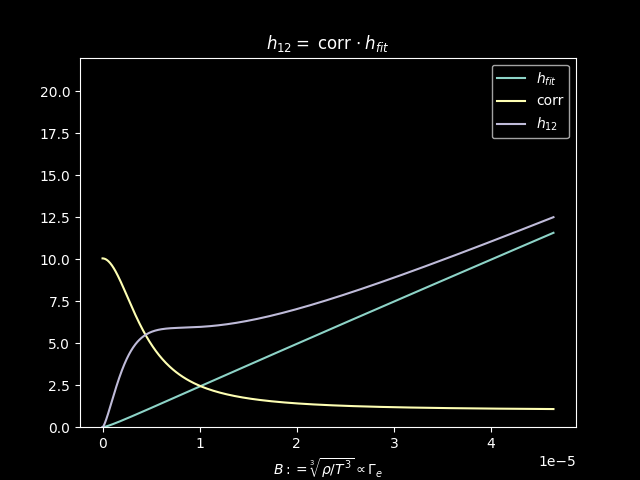

In [56]:
%matplotlib widget

fig3, ax3 = plt.subplots()

params3 = {
    "abar": FloatSlider(value=1, min=1, max=52.43965444432472),
    "zbar": FloatSlider(value=1, min=1, max=100),
    "z2bar": FloatSlider(value=150, min=1, max=713.3104742534674),
    "z1": IntSlider(value=1, min=1, max=20),
    "z2": IntSlider(value=1, min=1, max=20),
    "A__": FloatSlider(value=1, min=1, max=33.35*q)
}

ax3.set_title("$h_{12} =$ corr $\\cdot \\: h_{fit}$")

ax3.set_xlabel("$B := \\sqrt[3]{\\rho/T^3} \\propto \\Gamma_e$")
ax3.set_ylim(0, 22)
#ax3.set_xscale("log")
#ax3.set_yscale("log")

# Create initial plot
H, = ax3.plot(B__, H__, label="$h_{fit}$")
#dH_dB, = ax3.plot(B__, np.log10(np.gradient(H__, B__)), label="$dH_{fit}/dB$")
corr, = ax3.plot(B__, corr__, label="corr")
scor, = ax3.plot(B__, H__*corr__, label="$h_{12}$")

ax3.legend()

# Create function to be called when slider value is changed
@interact(**params3)
def update3(**kwargs) -> None:
    A__new = 10**kwargs["A__"]
    del kwargs["A__"]

    T__new, D__new = AB_to_TD(A__new, B__)

    H__new, corr__new = F_fit(T__new, D__new, **kwargs, **fixed_kwargs)

    H.set_ydata(H__new)
    #dH_dB.set_ydata(np.log10(np.gradient(H__new, B__)))
    corr.set_ydata(corr__new)
    scor.set_ydata(H__new*corr__new)

# Show graph
#fig3.show()

The corrective factor is of the form
$$
    \mathrm{corr} = \frac{c + \Gamma_{12}^2}{1 + \Gamma_{12}^2},
$$
where $\Gamma_{12} \propto \Gamma_e$ and $c$ is a function of $\bar{Z}, \overline{Z^2}, Z_1, Z_2$. Increasing $Z_1, Z_2$ decreases its height and increases its steepness, increasing $\bar{Z}, \overline{Z^2}$ shrinks or stretches it vertically, and increasing $\bar{A}$ stretches it horizontally.

Notice that $h_{\mathrm{fit}}$ is mostly linear, but increases in the $\rho, T$ parameter $A$ cause it to bend downwards at higher $B$.